# CNN - Modelling (Binary + TH + Inception)

# 1. Construct `ImageDataGenerator` Instance

In [1]:
import tensorflow as tf
%matplotlib inline

print(tf.__version__)

2.4.2


In [2]:
! nvidia-smi

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Thu Aug 12 11:20:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   39C    P8    10W /  70W |      0MiB / 15109MiB |      0%    

We center and standardize all images at per image level.

Image flips, 180 degree image rotations and image brightness is suitable for data augmentation. However, shift and zoom are not appropriate because some crackes are located at the edge of some images. Zoom and shift may remove those crackes.

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    samplewise_center=True,
                                    samplewise_std_normalization=True)

datagen_test = ImageDataGenerator(samplewise_center=True,
                                   samplewise_std_normalization=True)

Then, load the data from directory: to relieve the burden of memory usage, import the image as 150 $\times$ 150 squares.

In [4]:
SRC_BINARY = "/home/ubuntu/crack/TH-Binary/"

from crack_utils import load_binary_dataset

x_train, x_test, y_train, y_test = load_binary_dataset(SRC_BINARY, (150,150))

train_it = datagen_train.flow(x_train, y_train, batch_size=64, seed=100)
test_it = datagen_test.flow(x_test, y_test, batch_size=64, seed=100)

# 2. Inception Model

## 2.1 Baseline Model 

We consider Inception module in our baseline model.

### 2.2.2 One Block Inception Model

In [5]:
from crack_utils import naive_inception_module, classification_block, binary_compile, feature_reduce_block
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

def one_block_Inception():
    # define model input
    visible = Input(shape=(150, 150, 1))
    # add inception module
    layer = naive_inception_module(visible, 64, 128, 32)
    # add feature reduce block
    layer = feature_reduce_block(layer, 32, (2,2))
    # add classification block
    layer = classification_block(layer, 16)
    # create model
    model = Model(inputs=visible, outputs=layer)
    return model

# create model instance
model = one_block_Inception()
binary_compile(model, 0.001, 0.9)
model.summary()

Extension horovod.torch has not been built: /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2021-08-12 11:20:57.870 ip-172-31-5-51:14496 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-08-12 11:20:57.892 ip-172-31-5-51:14496 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 1) 0                                            
_________________________________________________

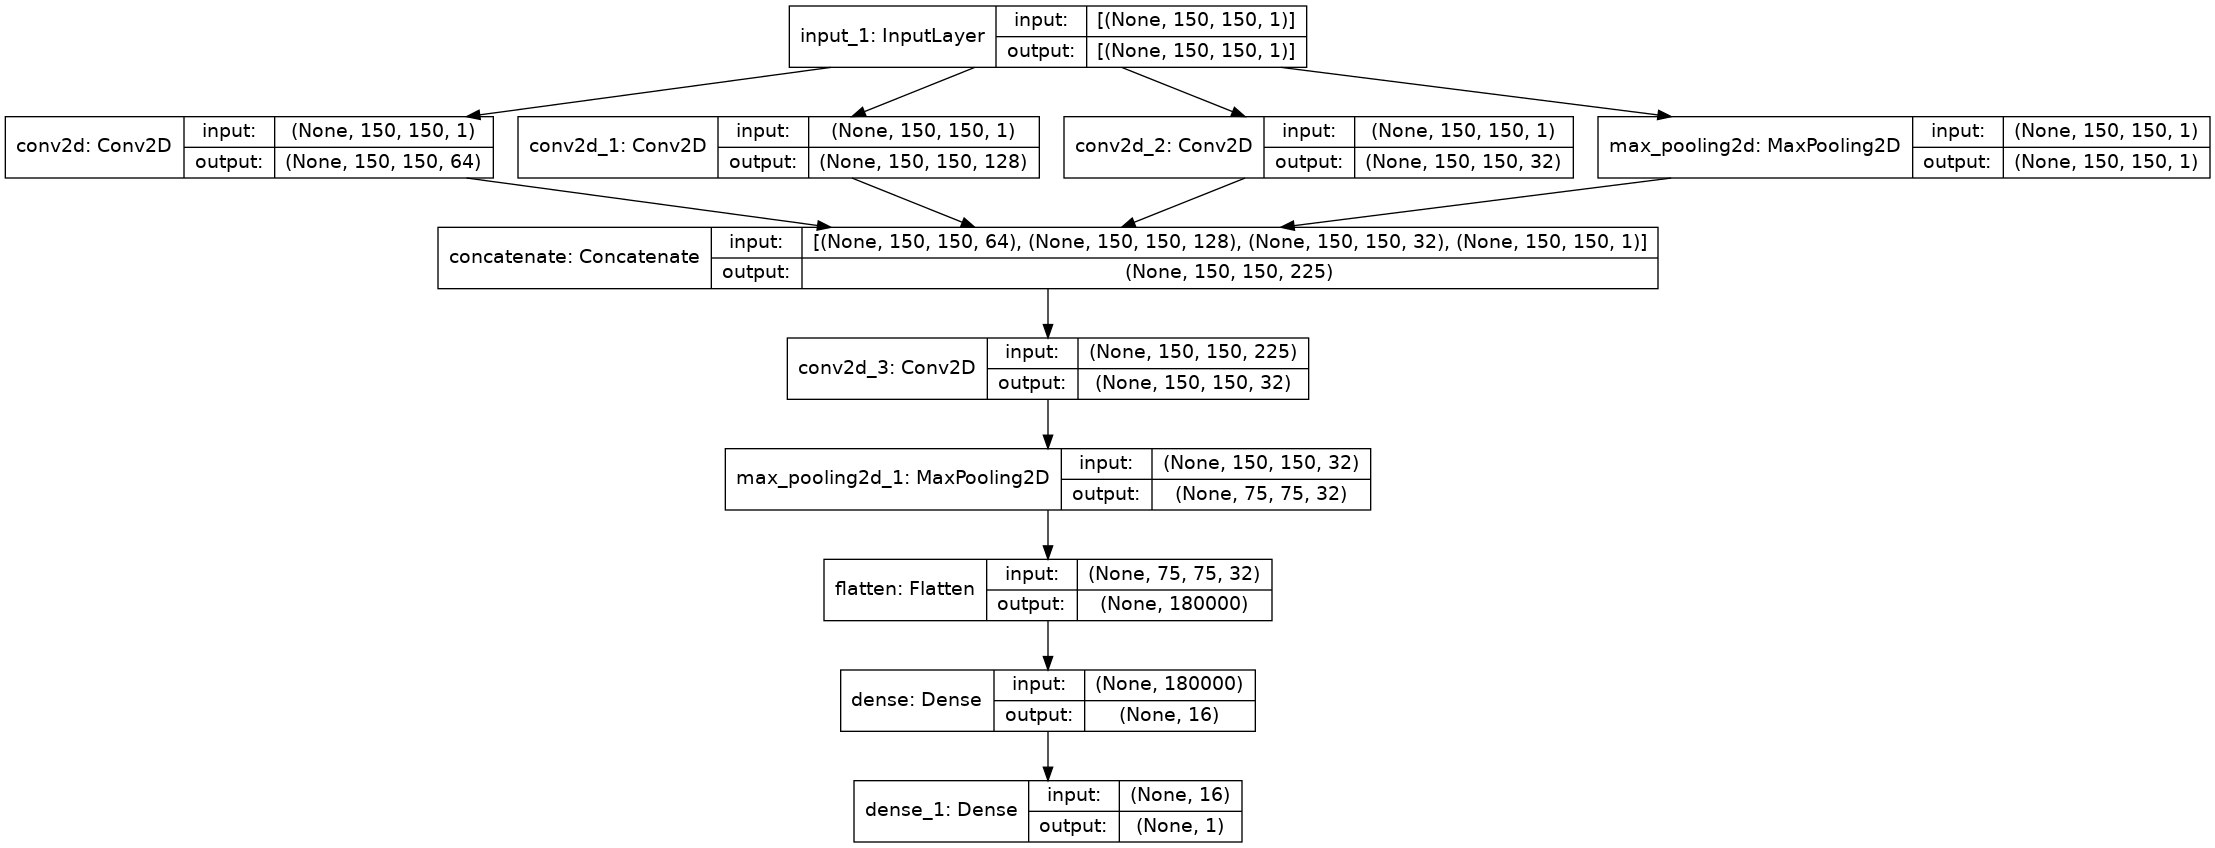

In [6]:
from tensorflow.keras.utils import plot_model

# plot model architecture
plot_model(model, show_shapes=True, to_file='model_image/Bi_TH_Inception_1.png')

In [7]:
%%time

histories = dict()

histories["Bi_TH_Inception_1"] = model.fit(x=train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 2min 59s, sys: 16 s, total: 3min 15s
Wall time: 7min 44s


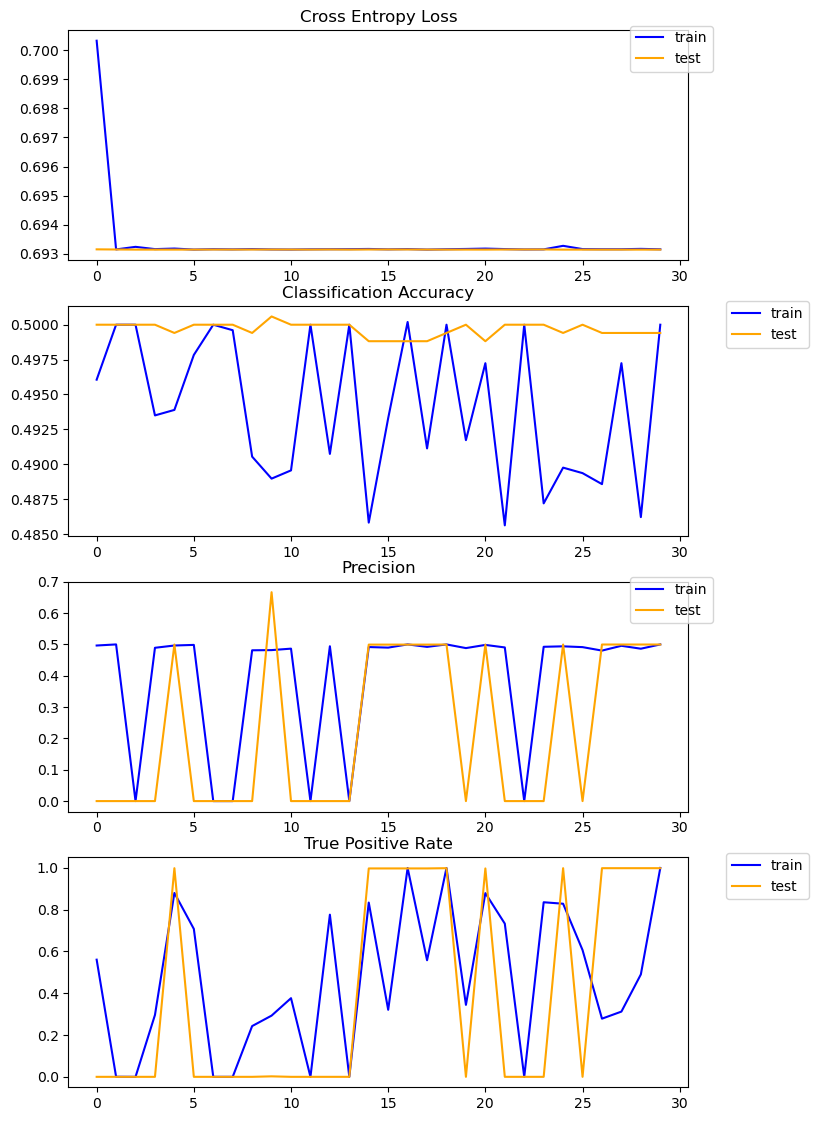

In [8]:
from crack_utils import summarize_diagnostics_binary
                                           
summarize_diagnostics_binary(histories["Bi_TH_Inception_1"], "model_plot/Bi_TH_Inception_1.png")

In [9]:
from crack_utils import show_result

show_result(model, test_it)

Test loss: 0.69
Test Accuracy: 0.50
Test Precision: 0.50
Test True Positive Rate: 1.00


### 2.1.2 Two Block Inception Model

In [10]:
def two_block_Inception():
    # define model input
    visible = Input(shape=(150, 150, 1))
    # add inception module
    layer = naive_inception_module(visible, 64, 128, 32)
    # add feature reduce block
    layer = feature_reduce_block(layer, 32, (2,2))
    # add inception module
    layer = naive_inception_module(layer, 96, 192, 64)
    # add feature reduce block
    layer = feature_reduce_block(layer, 32, (2,2))
    # add classification block
    layer = classification_block(layer, 16)
    # create model
    model = Model(inputs=visible, outputs=layer)
    return model

# create model instance
model = two_block_Inception()
binary_compile(model, 0.001, 0.9)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 150, 150, 64) 128         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 150, 150, 128 1280        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 150, 150, 32) 832         input_2[0][0]                    
____________________________________________________________________________________________

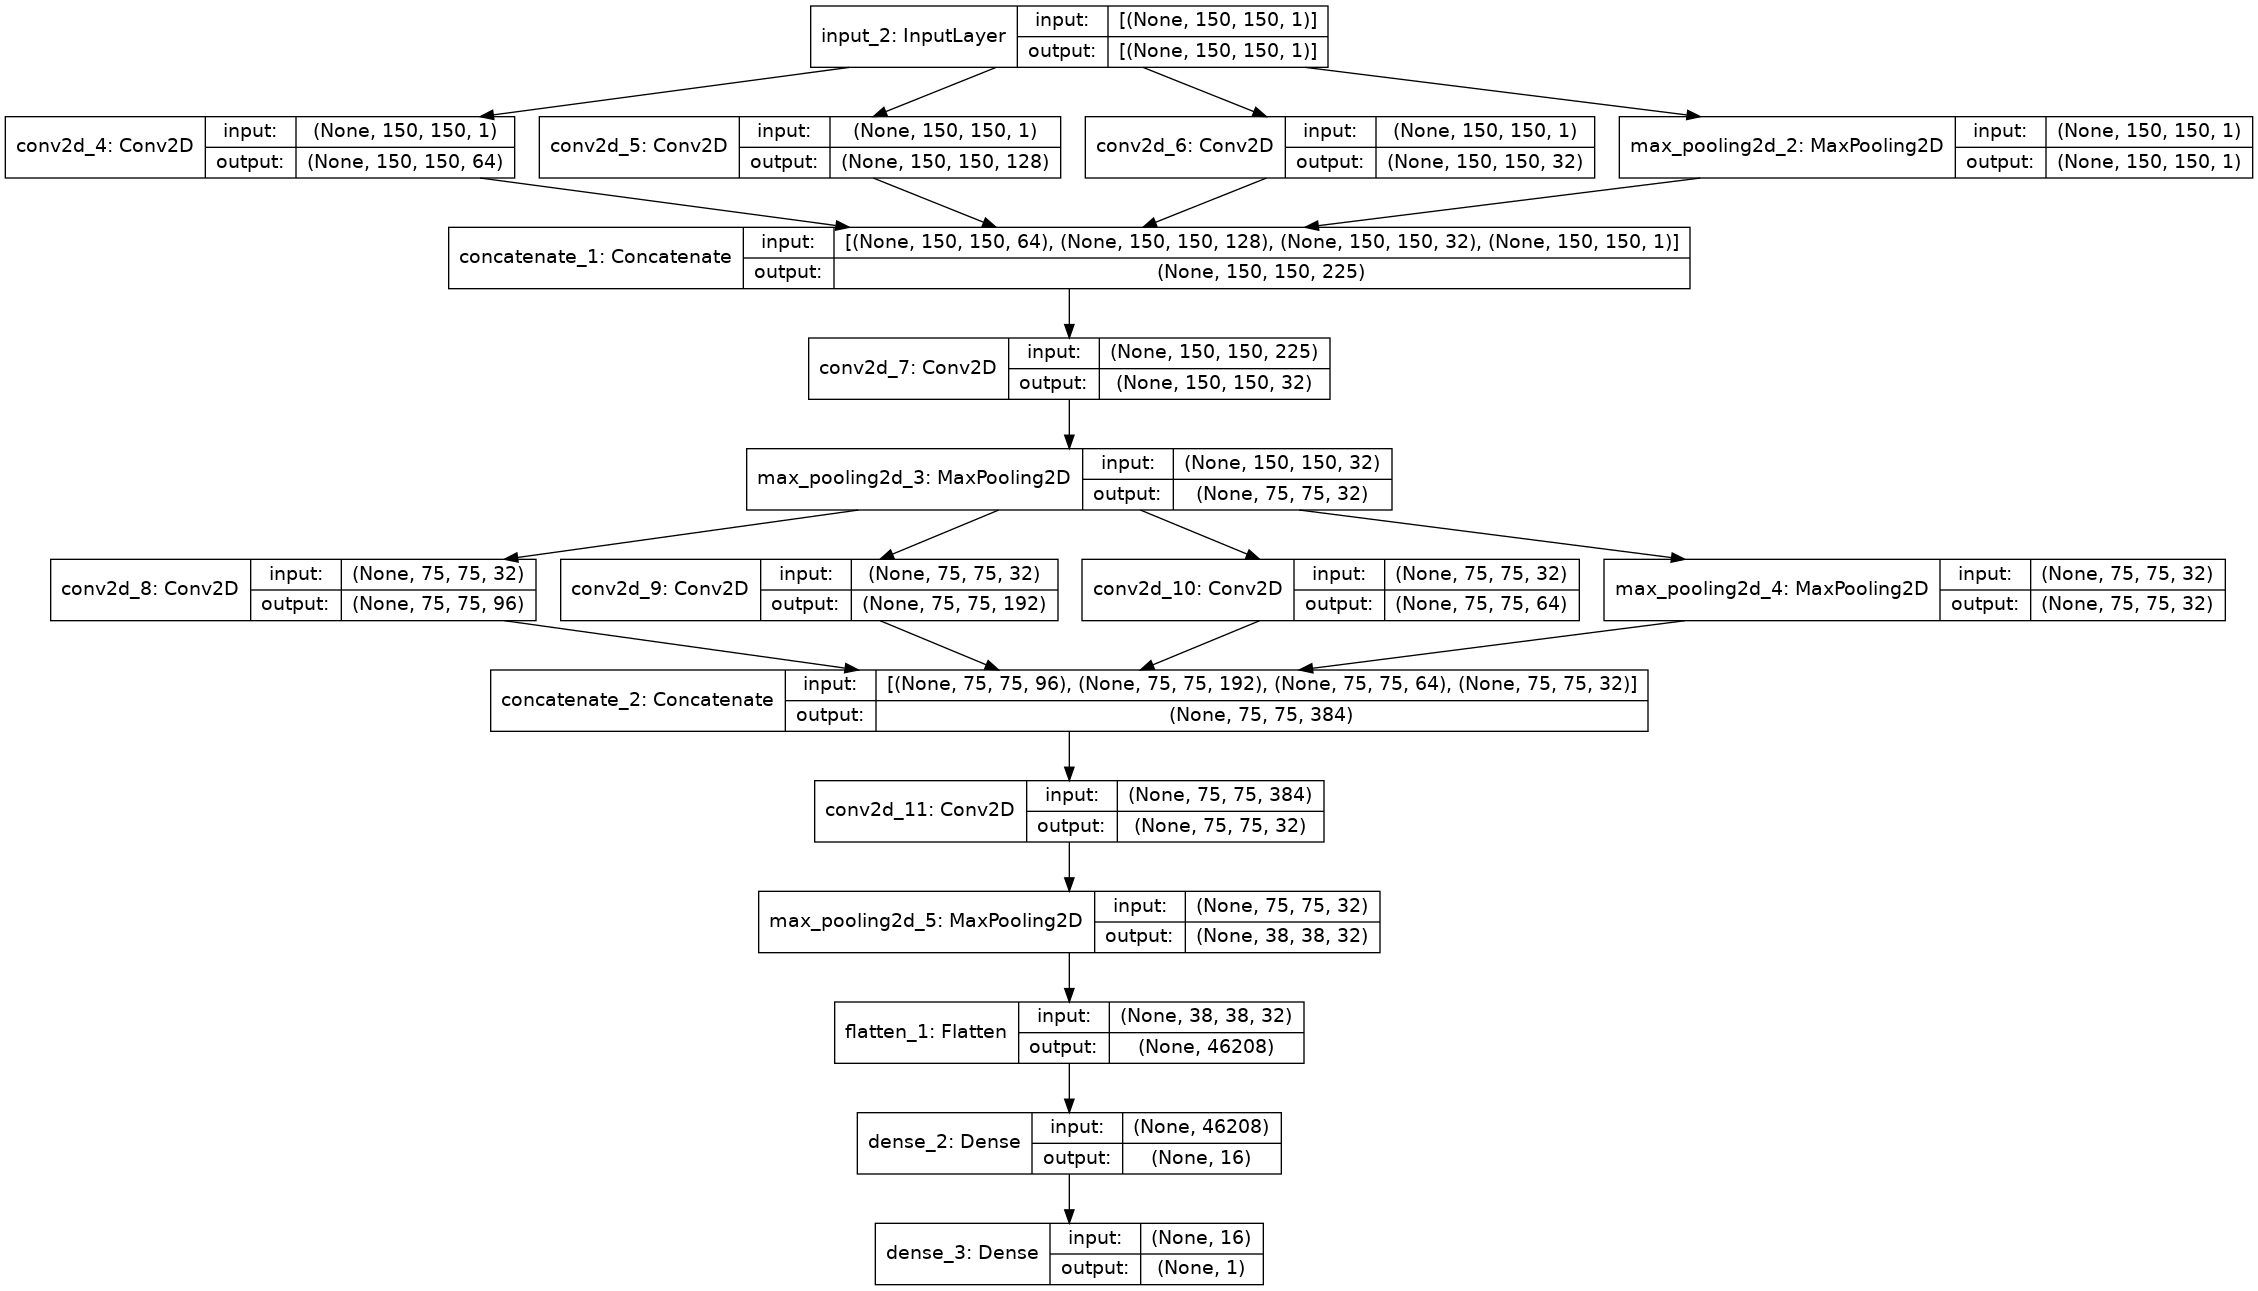

In [11]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='model_image/Bi_TH_Inception_2.png')

In [12]:
%%time

histories["Bi_TH_Inception_2"] = model.fit(train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 4min 33s, sys: 26.1 s, total: 4min 59s
Wall time: 11min 51s


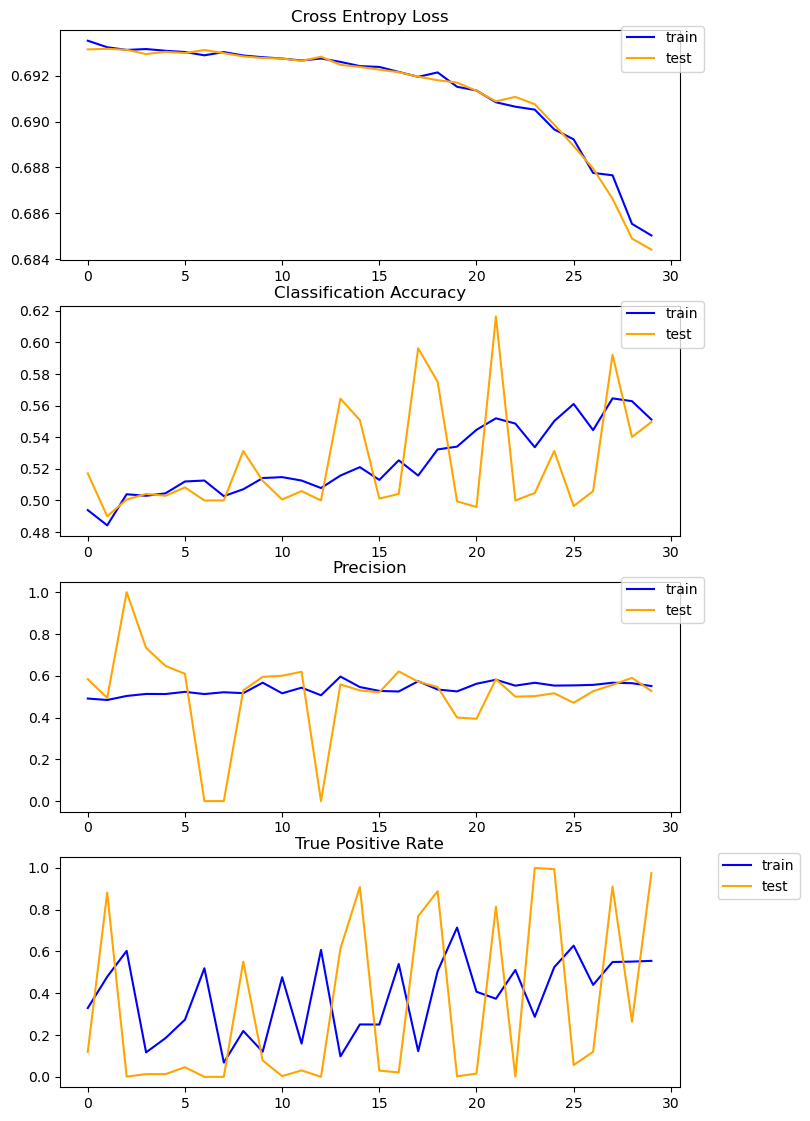

In [13]:
summarize_diagnostics_binary(histories["Bi_TH_Inception_2"], "model_plot/Bi_TH_Inception_2.png")

In [14]:
show_result(model, test_it)

Test loss: 0.68
Test Accuracy: 0.55
Test Precision: 0.53
Test True Positive Rate: 0.97


## 2.2 Model Improvements

### 2.2.1 Dropout Regularization



In [15]:
from tensorflow.keras.layers import Dropout

def two_block_Inception_dropout():
    # define model input
    visible = Input(shape=(150, 150, 1))
    # add inception module
    layer = naive_inception_module(visible, 64, 128, 32)
    # add feature reduce block
    layer = feature_reduce_block(layer, 32, (2,2))
    layer = Dropout(0.3)(layer)
    # add inception module
    layer = naive_inception_module(layer, 96, 192, 64)
    # add feature reduce block
    layer = feature_reduce_block(layer, 32, (2,2))
    layer = Dropout(0.4)(layer)
    # add classification block
    layer = classification_block(layer, 16)
    # create model
    model = Model(inputs=visible, outputs=layer)
    return model

# create model instance
model = two_block_Inception_dropout()
binary_compile(model, 0.001, 0.9)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 150, 150, 64) 128         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 150, 150, 128 1280        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 150, 150, 32) 832         input_3[0][0]                    
____________________________________________________________________________________________

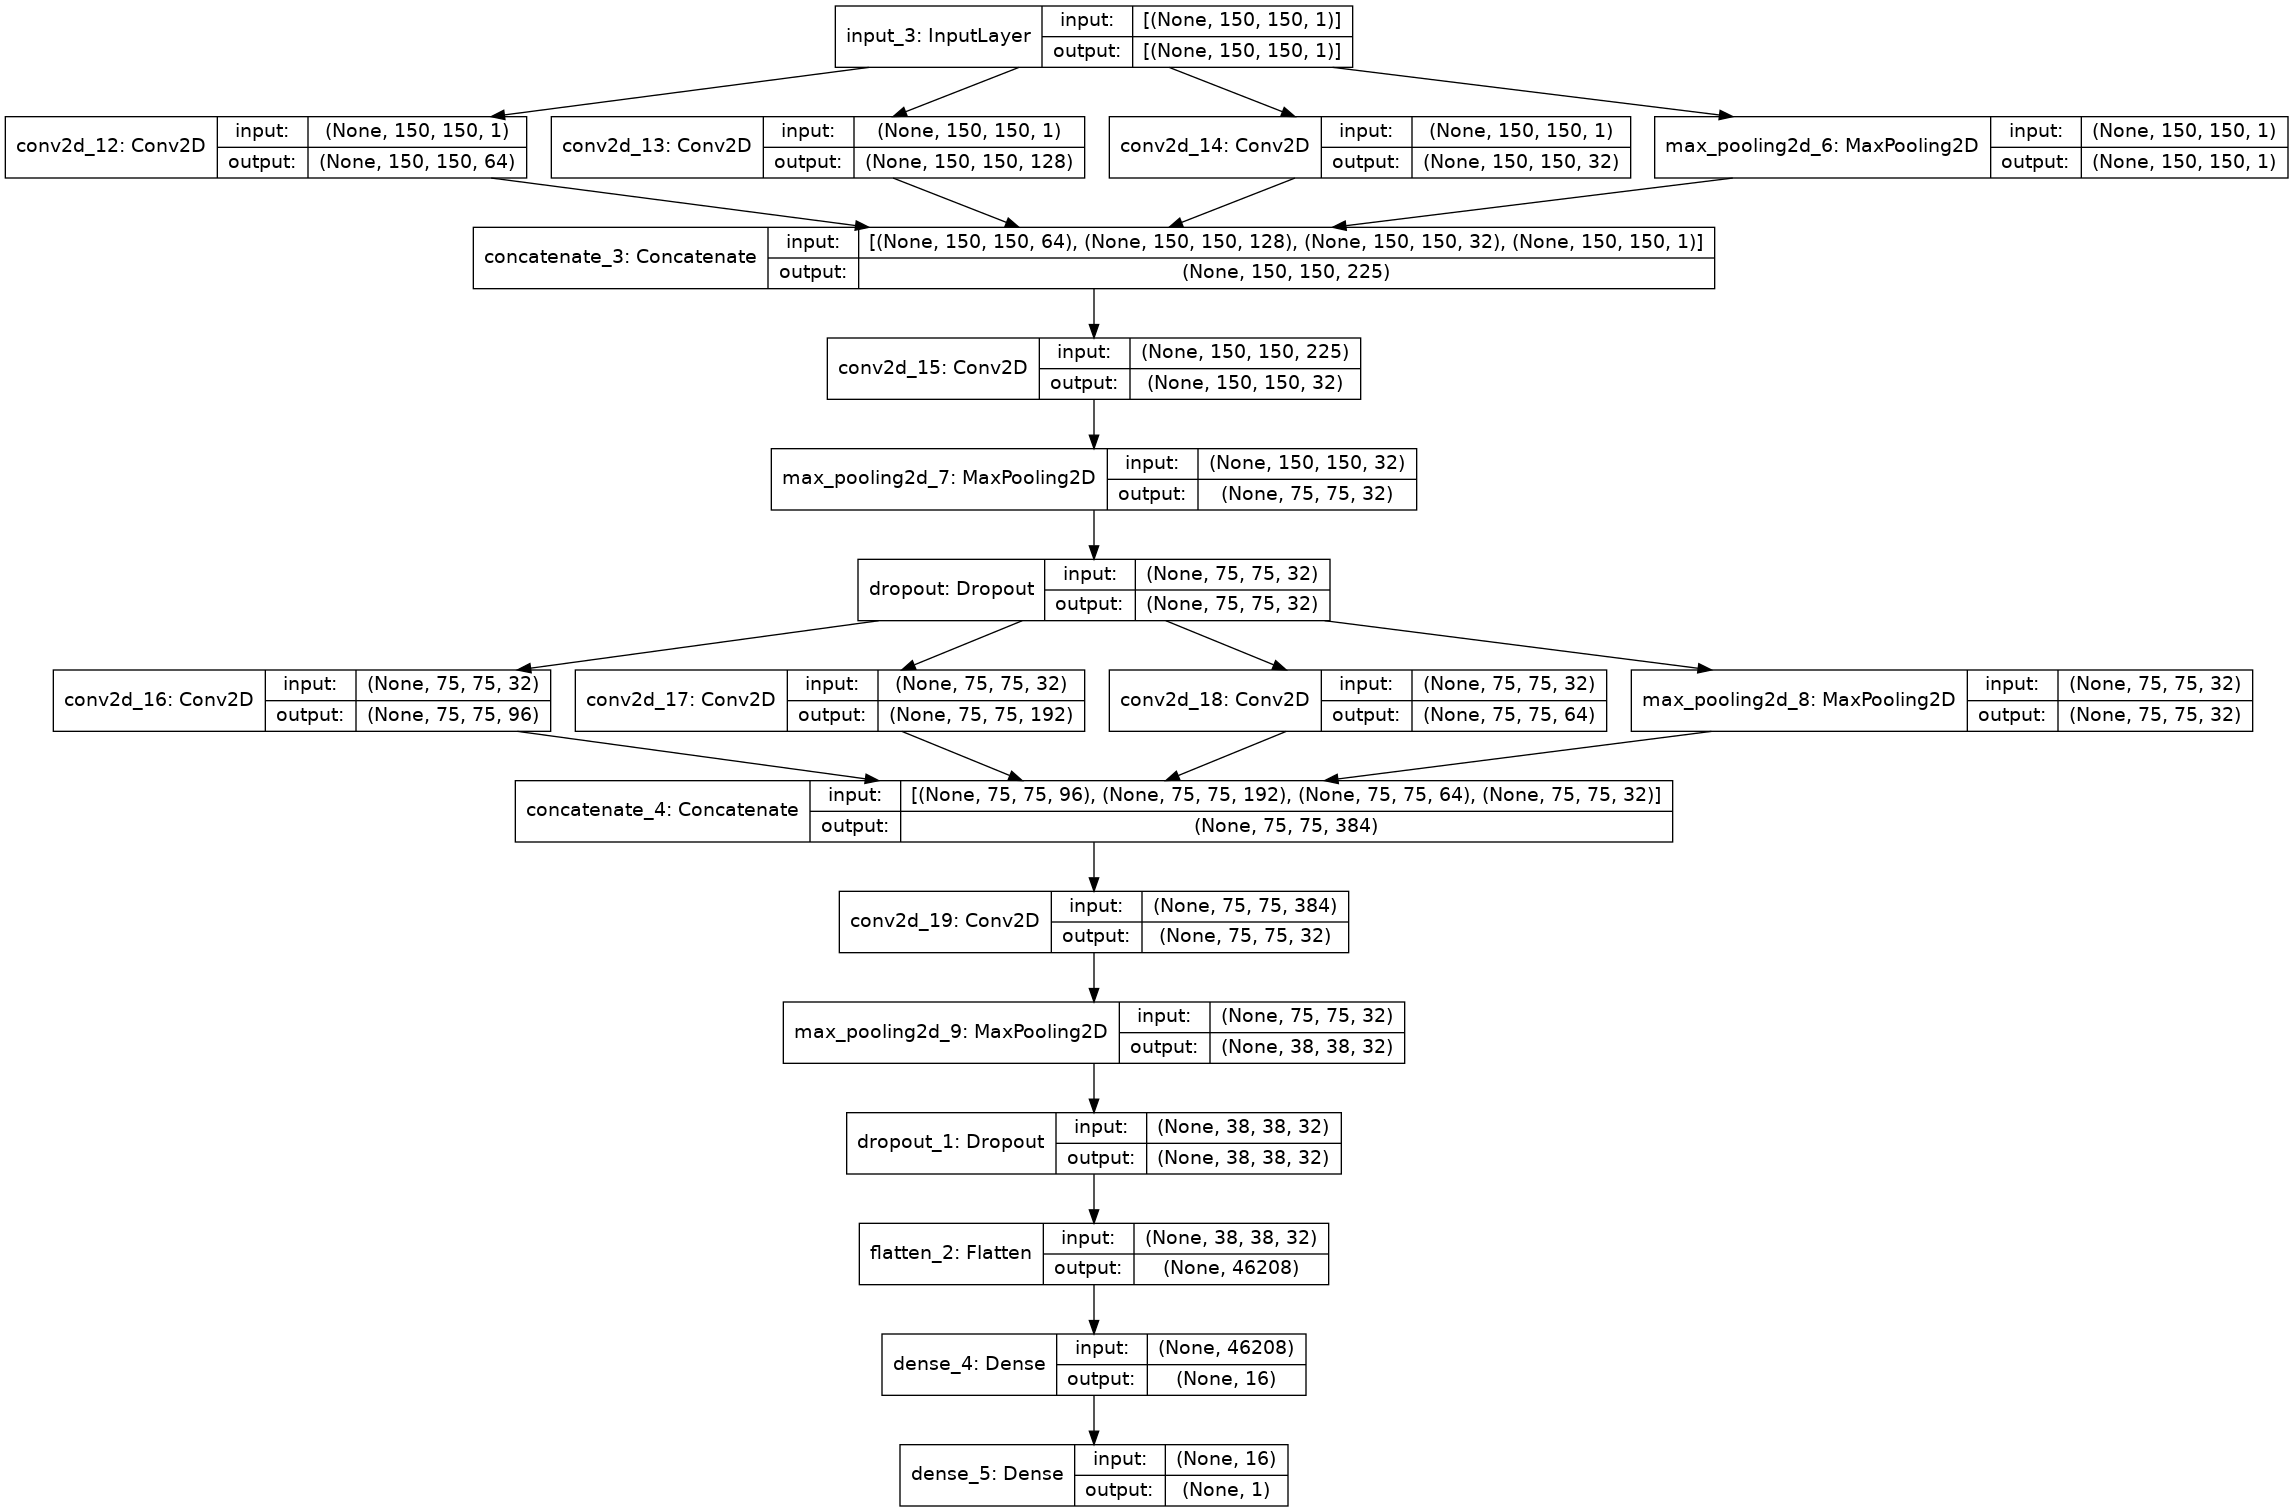

In [16]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='model_image/Bi_TH_Inception_2_dropout.png')

In [17]:
%%time

histories["Bi_TH_Inception_2_dropout"] = model.fit(train_it, 
              steps_per_epoch=len(train_it), validation_data=test_it, 
              validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 4min 17s, sys: 26.9 s, total: 4min 44s
Wall time: 11min 39s


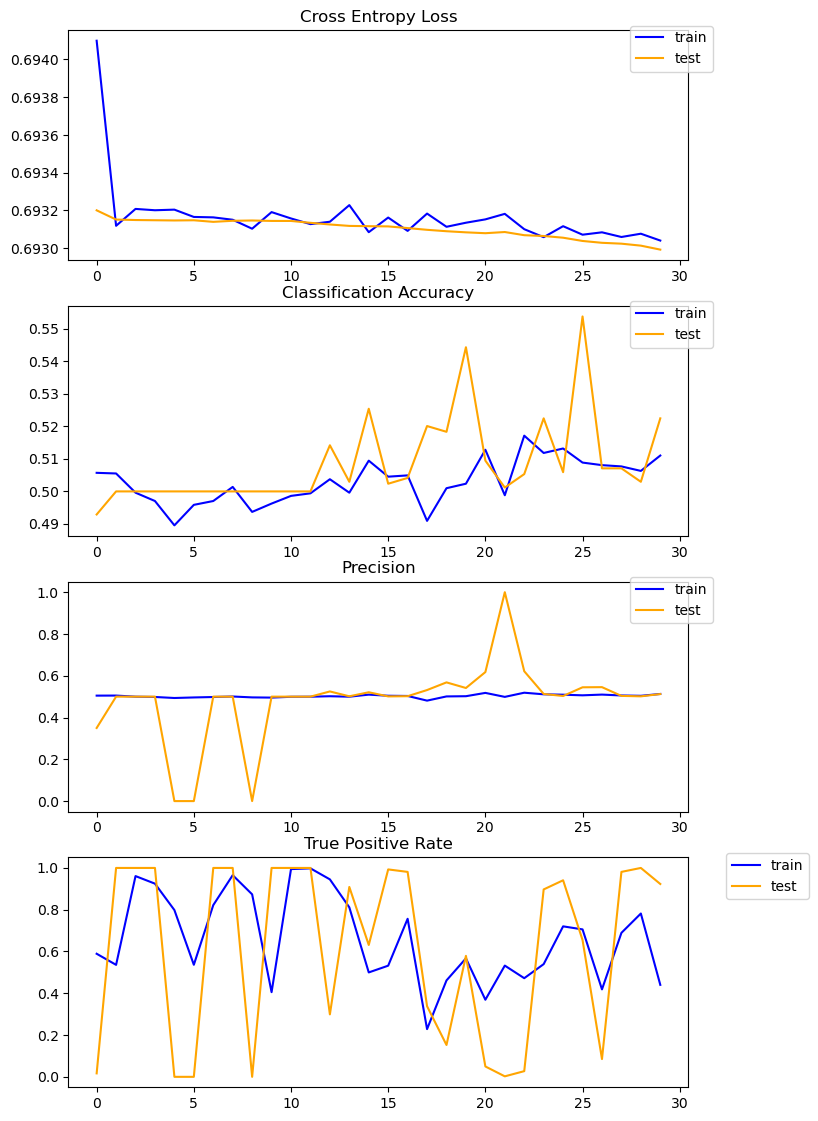

In [18]:
summarize_diagnostics_binary(histories["Bi_TH_Inception_2_dropout"], "model_plot/Bi_TH_Inception_2_dropout.png")

In [19]:
show_result(model, test_it)

Test loss: 0.69
Test Accuracy: 0.52
Test Precision: 0.51
Test True Positive Rate: 0.92


### 2.2.1 Weight Decay + Dropout

In [20]:
from tensorflow.keras.regularizers import l2

def two_block_Inception_dropout_decay():
    # define model input
    visible = Input(shape=(150, 150, 1))
    # add inception module
    layer = naive_inception_module(visible, 64, 128, 32, decay=l2(0.01))
    # add feature reduce block
    layer = feature_reduce_block(layer, 32, (2,2))
    layer = Dropout(0.3)(layer)
    # add inception module
    layer = naive_inception_module(layer, 96, 192, 64, decay=l2(0.01))
    # add feature reduce block
    layer = feature_reduce_block(layer, 32, (2,2))
    layer = Dropout(0.4)(layer)
    # add classification block
    layer = classification_block(layer, 16, decay=l2(0.01))
    # create model
    model = Model(inputs=visible, outputs=layer)
    return model

# create model instance
model = two_block_Inception_dropout_decay()
binary_compile(model, 0.001, 0.9)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 150, 150, 64) 128         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 150, 150, 128 1280        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 150, 150, 32) 832         input_4[0][0]                    
____________________________________________________________________________________________

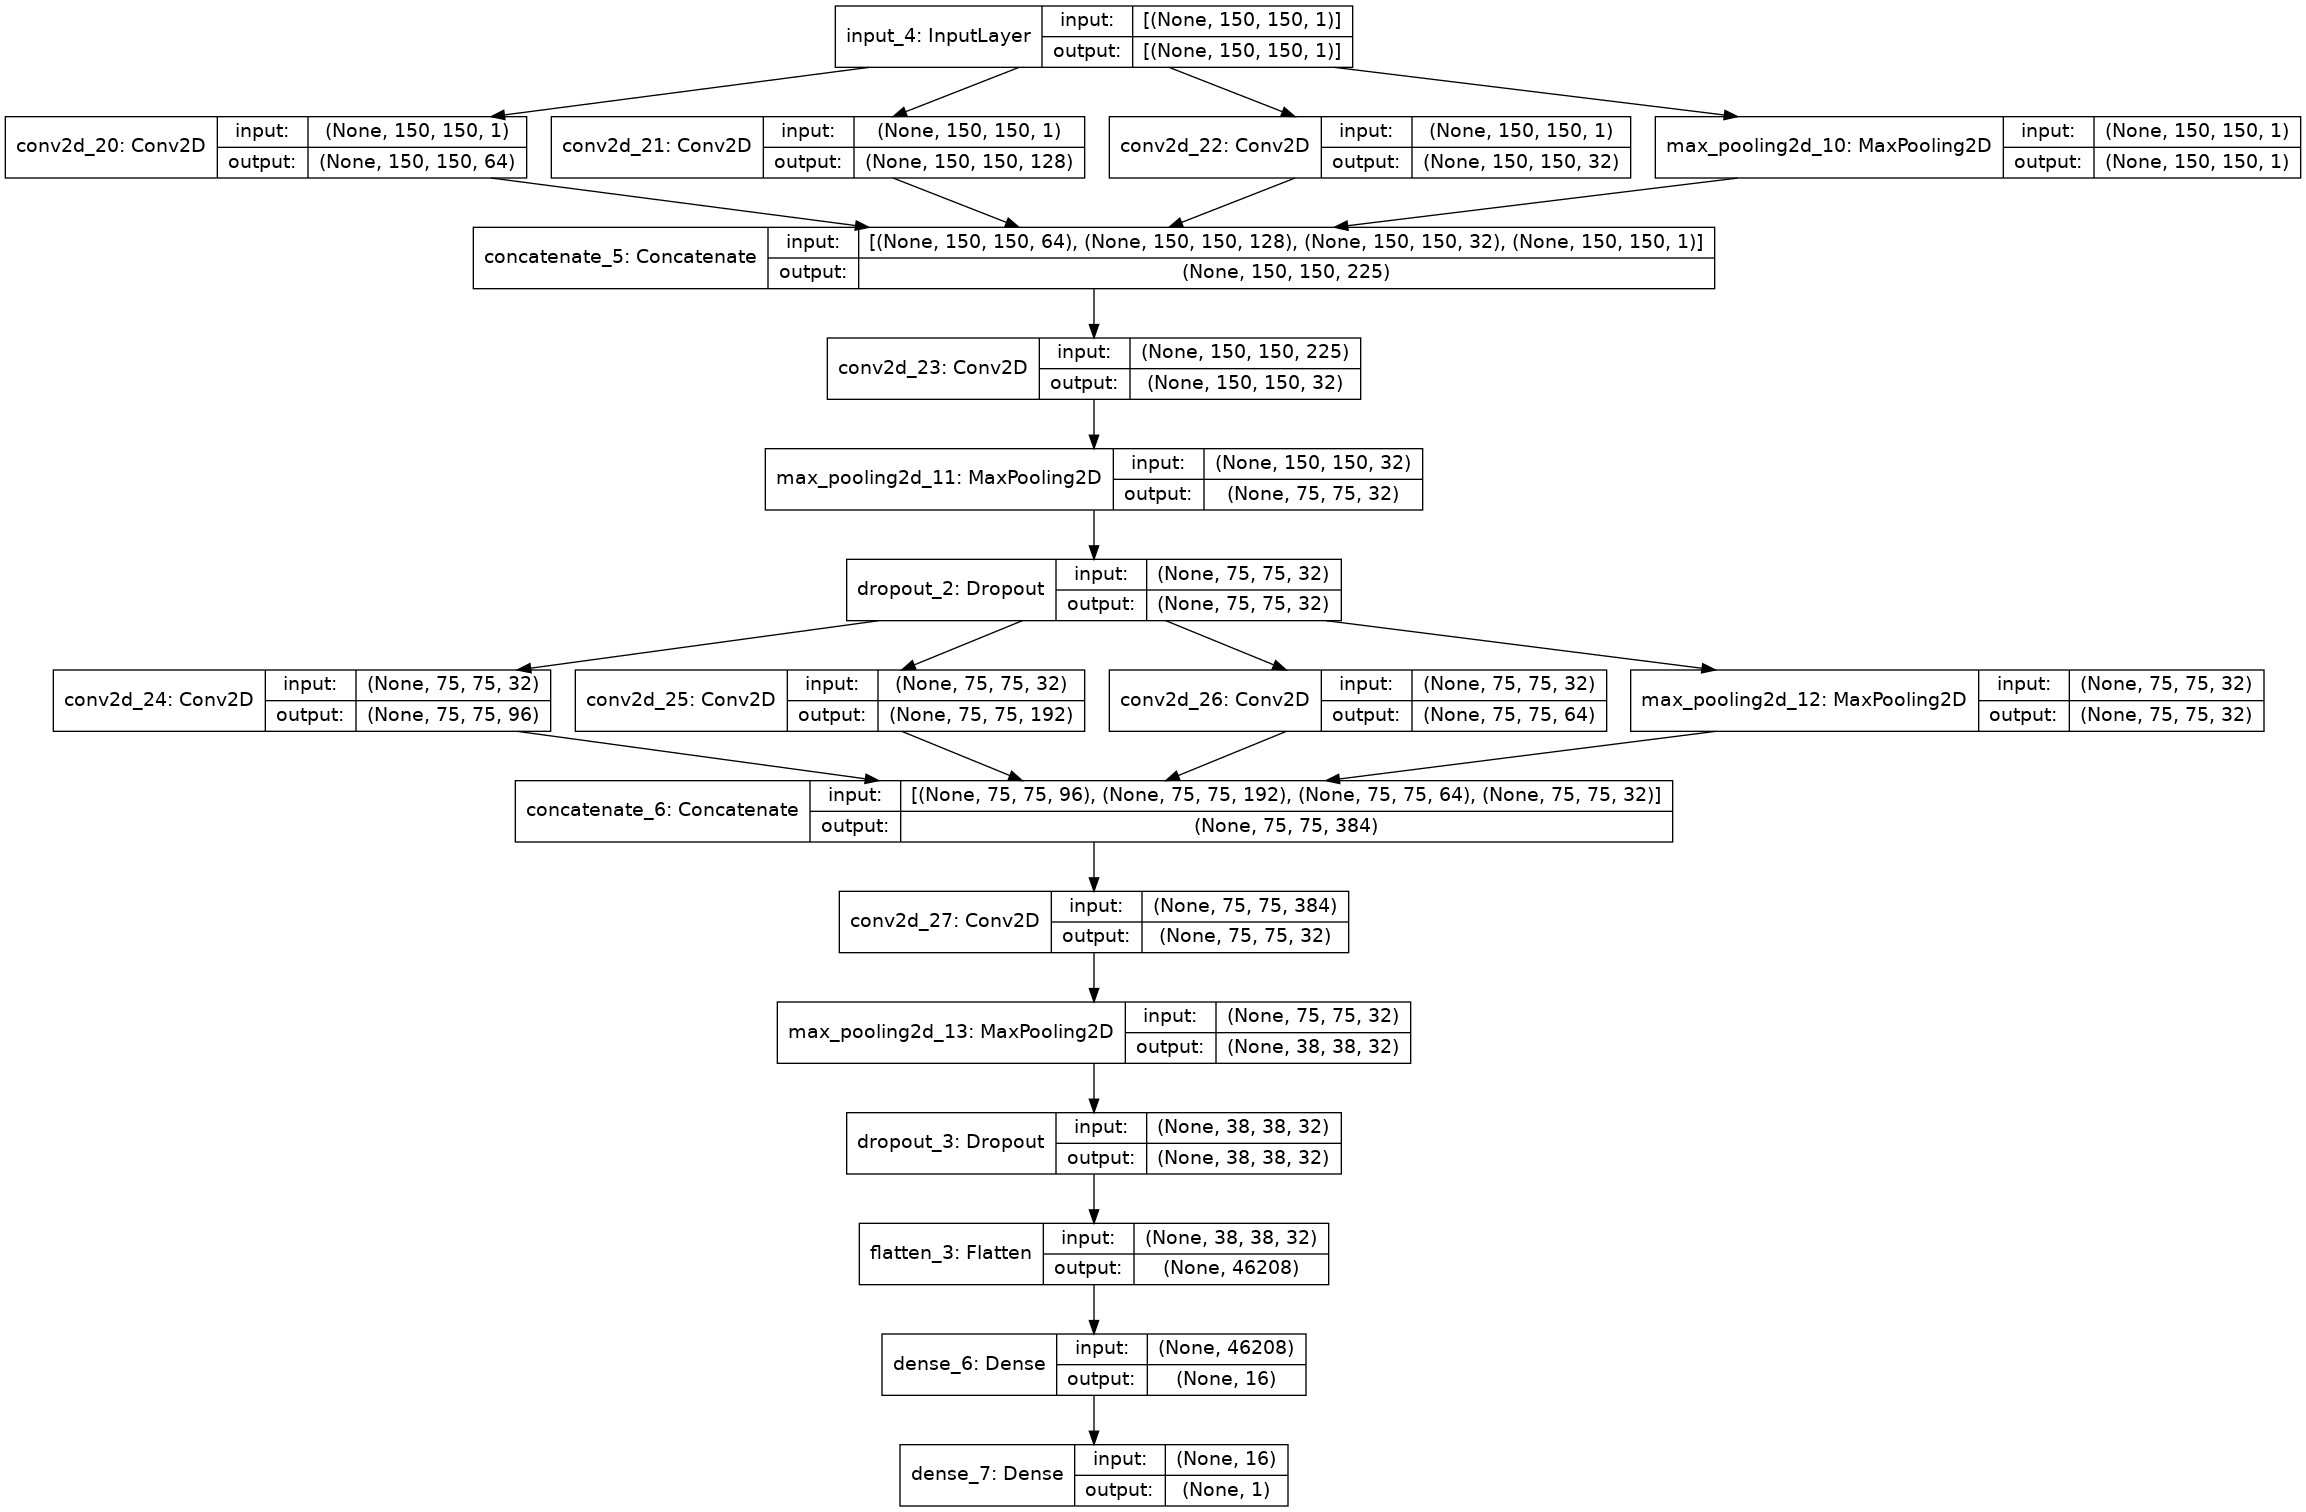

In [21]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='model_image/Bi_TH_Inception_2_dropout_decay.png')

In [22]:
%%time

histories["Bi_TH_Inception_2_dropout_decay"] = model.fit(train_it, 
                               steps_per_epoch=len(train_it), validation_data=test_it, 
                               validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 4min 31s, sys: 26.5 s, total: 4min 58s
Wall time: 11min 44s


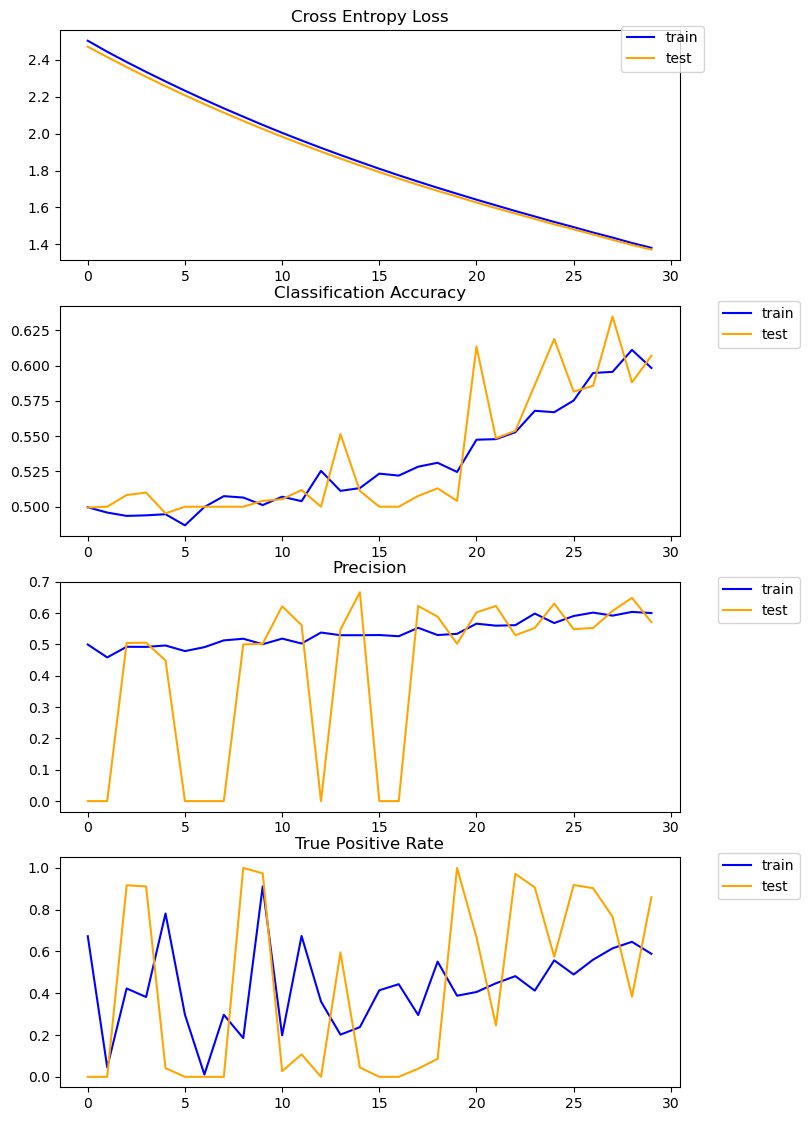

In [23]:
summarize_diagnostics_binary(histories["Bi_TH_Inception_2_dropout_decay"], 
                             "model_plot/Bi_TH_Inception_2_dropout_decay.png")

In [24]:
show_result(model, test_it)

Test loss: 1.37
Test Accuracy: 0.61
Test Precision: 0.57
Test True Positive Rate: 0.86


# 3. Summary

30th epoch result:

In [25]:
from crack_utils import get_percentile_result

result_30 = get_percentile_result(histories, 30)
result_30.round(2)

,Bi_TH_Inception_1,Bi_TH_Inception_2,Bi_TH_Inception_2_dropout,Bi_TH_Inception_2_dropout_decay
Loss,0.69,0.68,0.69,1.37
Accuracy,0.50,0.55,0.52,0.61
Precision,0.50,0.53,0.51,0.57
TPR,1.00,0.97,0.92,0.86


21-30 epochs (Average):

In [26]:
from crack_utils import get_avg_result

avg_result = get_avg_result(histories, start_epoch=21)
avg_result.round(2)

,Bi_TH_Inception_1,Bi_TH_Inception_2,Bi_TH_Inception_2_dropout,Bi_TH_Inception_2_dropout_decay
Loss,0.69,0.69,0.69,1.48
Accuracy,0.50,0.54,0.51,0.59
Precision,0.28,0.53,0.58,0.58
TPR,0.55,0.57,0.61,0.73


Compare each model:

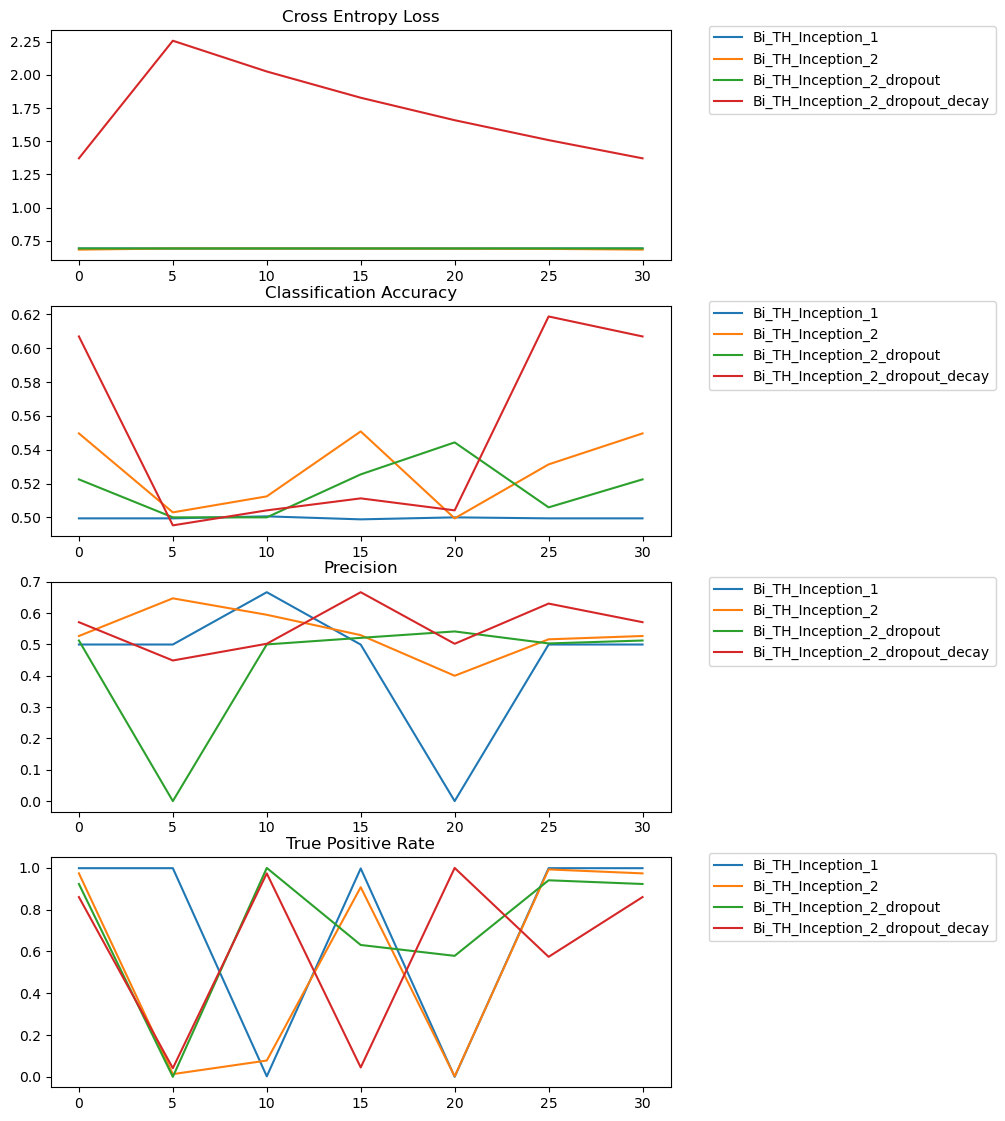

In [27]:
from crack_utils import compare_all_result

compare_all_result(histories, filename="model_plot/Compare_Bi_TH_Inception.png", end=30, step=5)

Save epochs history:

In [28]:
from crack_utils import save_history

save_history(histories, folder="epochs_history")